In [1]:
import tarfile
import pyarrow.parquet as pq
##ask about how to use totals.gpus to get gpu_util
metrics = {
    "slurm": ["s21.totals.cpus", "s21.totals.gpus", "s21.totals.memory", "s21.totals.total_nodes"], 
    "ganglia": ["load_five", "gpu_temp", "sm_clock"]  

}

In [2]:
import pandas as pd
import numpy as np
from functools import reduce


In [3]:
dfs = []
gpus = []

In [4]:
with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    for metric in metrics["slurm"]:
        alloc = tf.getmember(f"year_month=22-06/plugin=slurm_pub/metric={metric}_alloc/a_0.parquet")
        df_alloc = pq.read_table(tf.extractfile(alloc)).to_pandas()
        df_alloc = df_alloc.groupby("timestamp", as_index=False)["value"].sum()


        config = tf.getmember(f"year_month=22-06/plugin=slurm_pub/metric={metric}_config/a_0.parquet")
        df_config = pq.read_table(tf.extractfile(config)).to_pandas()
        df_config = df_config.groupby("timestamp", as_index=False)["value"].sum()


        eligible = tf.getmember(f"year_month=22-06/plugin=slurm_pub/metric={metric}_eligible/a_0.parquet")
        df_eligible = pq.read_table(tf.extractfile(config)).to_pandas()
        df_eligible = df_config.groupby("timestamp", as_index=False)["value"].sum()

        base = metric.split('.')[-1]
        util_name_1 = f"{base}_util_cfg"
        merged_cfg = pd.merge(df_alloc, df_config, on="timestamp", suffixes=("_alloc", "_config"))
        merged_cfg[util_name_1] = (merged_cfg["value_alloc"] / merged_cfg["value_config"]).clip(0, 1)

        util_name_2 = f"{base}_util_elig"
        merged_elig = pd.merge(df_alloc, df_eligible, on="timestamp", suffixes=("_alloc", "_elig"))
        merged_elig[util_name_2] = (merged_elig["value_alloc"] / merged_elig["value_elig"]).clip(0, 1)


        merged = pd.merge(
            merged_cfg[["timestamp", util_name_1]],
            merged_elig[["timestamp", util_name_2]],
            on="timestamp",
            how="outer"
        ).sort_values("timestamp")

        merged["timestamp"] = merged["timestamp"].dt.floor("5min")
        merged = merged.groupby("timestamp", as_index=False)[[util_name_1, util_name_2]].mean()
        dfs.append(merged)
        

slurm_final = reduce(lambda l, r: pd.merge(l, r, on="timestamp"), dfs)
slurm_final.head()


,timestamp,cpus_util_cfg,cpus_util_elig,gpus_util_cfg,gpus_util_elig,memory_util_cfg,memory_util_elig,total_nodes_util_cfg,total_nodes_util_elig
0,2022-06-01 00:00:00+00:00,0.486820,0.486820,0.772865,0.772865,0.514640,0.514640,0.254733,0.254733
1,2022-06-01 00:05:00+00:00,0.484359,0.484359,0.770768,0.770768,0.512203,0.512203,0.252266,0.252266
2,2022-06-01 00:10:00+00:00,0.486933,0.486933,0.773358,0.773358,0.514852,0.514852,0.254857,0.254857
3,2022-06-01 00:15:00+00:00,0.487486,0.487486,0.773913,0.773913,0.515334,0.515334,0.255412,0.255412
4,2022-06-01 00:20:00+00:00,0.480682,0.480682,0.767160,0.767160,0.508878,0.508878,0.248659,0.248659


In [5]:
with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    ##
    metric = metrics["ganglia"][0]
    parq = tf.getmember(f"year_month=22-06/plugin=ganglia_pub/metric={metric}/a_0.parquet")
    df = pq.read_table(tf.extractfile(parq)).to_pandas()
    df = df[(df["timestamp"].dt.minute % 5 == 0) & (df["timestamp"].dt.second == 0)]
    df_load_five = df.groupby("timestamp", as_index=False)["value"].sum()
    df_load_five = df_load_five.rename(columns={"value": "Load Average "})

    metric = metrics["ganglia"][1]
    gpu_power = []
    gpu_power_cols = []
    for i in range(4):
        mname = f"Gpu{str(i)}_{metric}"
        gpux = tf.getmember(f"year_month=22-06/plugin=ganglia_pub/metric={mname}/a_0.parquet")
        gpu_df = pq.read_table(tf.extractfile(gpux)).to_pandas()
        gpu_df["timestamp"] = gpu_df["timestamp"].dt.floor("5min")
        gpu_df = gpu_df.groupby("timestamp", as_index=False)["value"].mean()
        gpu_df = gpu_df.rename(columns={"value": mname})
        gpu_power.append(gpu_df)
        gpu_power_cols.append(mname)


    metric = metrics["ganglia"][2]
    gpu_clock = []
    gpu_clock_cols = []
    for i in range(4):
        mname = f"Gpu{str(i)}_{metric}"
        gpux = tf.getmember(f"year_month=22-06/plugin=ganglia_pub/metric={mname}/a_0.parquet")
        gpu_df = pq.read_table(tf.extractfile(gpux)).to_pandas()
        gpu_df["timestamp"] = gpu_df["timestamp"].dt.floor("5min")
        gpu_df = gpu_df.groupby("timestamp", as_index=False)["value"].mean()
        gpu_df = gpu_df.rename(columns={"value": mname})
        gpu_clock.append(gpu_df)
        gpu_clock_cols.append(mname)


In [6]:
cleaned_power = reduce(lambda l, r: pd.merge(l, r, on="timestamp"), gpu_power)
cleaned_power = cleaned_power.assign(
    value=cleaned_power[gpu_power_cols].mean(axis=1, skipna=True)
)[["timestamp", "value"]]

cleaned_clock = reduce(lambda l, r: pd.merge(l, r, on="timestamp"), gpu_clock)
cleaned_clock = cleaned_clock.assign(
    value=cleaned_clock[gpu_clock_cols].mean(axis=1, skipna=True)
)[["timestamp", "value"]]


In [7]:
cleaned_power = cleaned_power.rename(columns={"value": "GPU_Temp_Avg"})
cleaned_clock = cleaned_clock.rename(columns={"value": "GPU_Clock_Avg"})

In [8]:
cleaned = pd.merge(cleaned_power, cleaned_clock, on="timestamp")

ganglia_final = pd.merge(cleaned, df_load_five, on="timestamp")
ganglia_final.head()


,timestamp,GPU_Temp_Avg,GPU_Clock_Avg,Load Average
0,2022-06-01 00:00:00+00:00,48.308346,1145.014781,41.580002
1,2022-06-01 00:05:00+00:00,48.378760,1141.862521,56.060001
2,2022-06-01 00:10:00+00:00,48.282819,1137.671072,79.220001
3,2022-06-01 00:20:00+00:00,48.214082,1130.093243,42.260002
4,2022-06-01 00:25:00+00:00,48.088682,1115.277164,88.689995


In [9]:
Xtrain = pd.merge(ganglia_final, slurm_final, on="timestamp")
Xtrain.head()


,timestamp,GPU_Temp_Avg,GPU_Clock_Avg,Load Average,cpus_util_cfg,cpus_util_elig,gpus_util_cfg,gpus_util_elig,memory_util_cfg,memory_util_elig,total_nodes_util_cfg,total_nodes_util_elig
0,2022-06-01 00:00:00+00:00,48.308346,1145.014781,41.580002,0.486820,0.486820,0.772865,0.772865,0.514640,0.514640,0.254733,0.254733
1,2022-06-01 00:05:00+00:00,48.378760,1141.862521,56.060001,0.484359,0.484359,0.770768,0.770768,0.512203,0.512203,0.252266,0.252266
2,2022-06-01 00:10:00+00:00,48.282819,1137.671072,79.220001,0.486933,0.486933,0.773358,0.773358,0.514852,0.514852,0.254857,0.254857
3,2022-06-01 00:20:00+00:00,48.214082,1130.093243,42.260002,0.480682,0.480682,0.767160,0.767160,0.508878,0.508878,0.248659,0.248659
4,2022-06-01 00:25:00+00:00,48.088682,1115.277164,88.689995,0.486845,0.486845,0.773327,0.773327,0.514615,0.514615,0.254887,0.254887


In [10]:
with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    m = tf.getmember("year_month=22-06/plugin=logics_pub/metric=Tot_ict/a_0.parquet")
    df_y = pq.read_table(tf.extractfile(m)).to_pandas()
    df_y['timestamp'] = pd.to_datetime(df_y['timestamp'])
    df_y['timestamp'] = df_y['timestamp'].dt.floor('5min')
    df_y = df_y.groupby('timestamp', as_index=False)["value"].mean()

print(df_y.shape)

(8273, 2)


In [11]:
df_y['delta'] = df_y['timestamp'].diff().dt.total_seconds().div(60)
gap_threshold = 200   # minutes
gap_idx = df_y.index[df_y['delta'] > gap_threshold][0]
split_time = df_y.loc[gap_idx, 'timestamp']
print(f"Largest gap found: {df_y.loc[gap_idx,'delta']:.1f} minutes at {split_time}")

df_y['post_gap_flag'] = (df_y['timestamp'] >= split_time).astype(int)


Largest gap found: 1555.0 minutes at 2022-06-23 14:00:00+00:00


In [12]:
df_y = df_y.drop(columns='delta')
df_y.head()

,timestamp,value,post_gap_flag
0,2022-06-01 00:00:00+00:00,872.420044,0
1,2022-06-01 00:05:00+00:00,870.920044,0
2,2022-06-01 00:10:00+00:00,865.679993,0
3,2022-06-01 00:15:00+00:00,873.779968,0
4,2022-06-01 00:20:00+00:00,865.820007,0


In [13]:
final_train = pd.merge(df_y, Xtrain, on="timestamp")
df = final_train.copy()

In [14]:
df = df.rename(columns={"value": "P_it"})
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=False)

df['hour'] = df['timestamp'].dt.hour.astype('Int64')
df = df.dropna(subset=['hour'])                        # in case any NaT slipped in
df['hour'] = df['hour'].astype(int)
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24.0)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24.0)
df = df.drop(columns=["hour"])


In [15]:
def createTargets(d): 
    d = d.dropna()
    y = d['P_it']
    x = d.drop(columns=['P_it', 'timestamp'])
    return x, y

In [17]:
df.to_csv("data.csv", index=False)

In [16]:
training = df[df['timestamp'] < split_time]
testing = df[df['timestamp'] >= split_time]
xtrain, ytrain = createTargets(training)
xtest, ytest = createTargets(testing)

n_test = len(xtest)
i_mid  = n_test // 2

xcal, ycal = xtest.iloc[:i_mid], ytest.iloc[:i_mid]

xtest, ytest = xtest.iloc[i_mid:], ytest.iloc[i_mid:]



In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNetCV
import statsmodels.api as sm

In [18]:
scaler = StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xcal_scaled   = scaler.transform(xcal)
xtest_scaled  = scaler.transform(xtest)

In [ ]:
##Lasso Model
lasso_cv = LassoCV(alphas=np.logspace(-3,1,100), cv=5)
lasso_cv.fit(xtrain_scaled, ytrain)

y_cal_pred = lasso_cv.predict(xcal_scaled)
bias = ycal.mean() - y_cal_pred.mean()

y_test_lasso = lasso_cv.predict(xtest_scaled) + bias 
mse_lasso = mean_squared_error(ytest, y_test_lasso)
r2_lasso = r2_score(ytest, y_test_lasso)

print(f"Mean Squared Error on test set: {mse_lasso:.2f}")
print(f"  R²   = {r2_lasso:.4f}")
coef_df = pd.Series(lasso_cv.coef_, index=xtrain.columns)
print("\nTop LASSO Coefficients:")
print(coef_df[coef_df != 0].sort_values(ascending=False).head(10))


Mean Squared Error on test set: 297.55
  R²   = 0.4289

Top LASSO Coefficients:
GPU_Power_Avg           4.600617e+01
GPU_Clock_Avg           1.338729e+01
memory_util_cfg         7.920814e+00
Load Average            9.705298e-01
memory_util_elig        1.460437e-14
total_nodes_util_cfg   -4.125489e+00
dtype: float64


In [ ]:
##Ridge

ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge_cv.fit(xtrain_scaled, ytrain)


y_cal_ridge = ridge_cv.predict(xcal_scaled)
bias = ycal.mean() - y_cal_ridge.mean()

y_test_ridge = ridge_cv.predict(xtest_scaled) + bias 
mse_ridge = mean_squared_error(ytest, y_test_ridge)
r2_ridge = r2_score(ytest, y_test_ridge)

print(f"Mean Squared Error on test set: {mse_lasso:.2f}")
print(f"  R²   = {r2_lasso:.4f}")
coef_df_ridge = pd.Series(ridge_cv.coef_, index=xtrain.columns)
print("\nTop LASSO Coefficients:")
print(coef_df_ridge[coef_df_ridge != 0].sort_values(ascending=False).head(10))

Mean Squared Error on test set: 297.55
  R²   = 0.4289

Top LASSO Coefficients:
GPU_Power_Avg       42.680670
GPU_Clock_Avg       18.108392
memory_util_cfg      6.156603
memory_util_elig     6.156603
Load Average         2.019352
hour_cos             0.779213
hour_sin            -0.551074
cpus_util_cfg       -0.627658
cpus_util_elig      -0.627658
gpus_util_elig      -0.887641
dtype: float64


In [ ]:
##Elastic Net
enet_cv = ElasticNetCV(
    alphas=np.logspace(-3, 1, 100), 
    l1_ratio=[.1, .3, .5, .7, .9], 
    cv=5, 
    n_jobs=-1, 
    max_iter=5000
    )
enet_cv.fit(xtrain_scaled, ytrain)

y_cal_enet = enet_cv.predict(xcal_scaled)
bias = ycal.mean() - y_cal_enet.mean()

y_test_enetcv = enet_cv.predict(xtest_scaled) + bias
mse_enet = mean_squared_error(ytest, y_test_enetcv)
r2_enet  = r2_score(ytest, y_test_enetcv)

print(f"Calibration MSE: {mse_enet:.2f}")
print(f"Calibration R²:  {r2_enet:.4f}")



Calibration MSE: 315.74
Calibration R²:  0.3940


In [19]:

xtrain_scaled_df = pd.DataFrame(xtrain_scaled, columns=xtrain.columns, index=xtrain.index)
xcal_scaled_df   = pd.DataFrame(xcal_scaled,   columns=xcal.columns,   index=xcal.index)
xtest_scaled_df  = pd.DataFrame(xtest_scaled,  columns=xtest.columns,  index=xtest.index)

# Add constant to DataFrames
xtrain_sm = sm.add_constant(xtrain_scaled_df, has_constant='add')
xcal_sm   = sm.add_constant(xcal_scaled_df,   has_constant='add')
xtest_sm  = sm.add_constant(xtest_scaled_df,  has_constant='add')

model = sm.OLS(ytrain, xtrain_sm).fit()


# Predict on calibration set
y_cal_pred = model.predict(xcal_sm)

# Compute bias (mean difference between actual and predicted)
bias = ycal.mean() - y_cal_pred.mean()

# Manually adjust intercept term to correct bias
# Create a copy of model params so we can shift the intercept
params_adj = model.params.copy()
params_adj['const'] += bias

# Predict on test set with adjusted intercept
y_test_pred = np.dot(xtest_sm, params_adj)

# Compute metrics
rmse_adj = np.sqrt(mean_squared_error(ytest, y_test_pred))
r2_adj   = r2_score(ytest, y_test_pred)

print(f"Adjusted Test RMSE: {rmse_adj:.3f}")
print(f"Adjusted Test R²:   {r2_adj:.3f}")


Adjusted Test RMSE: 17.446
Adjusted Test R²:   0.416


In [20]:
summary_table = model.summary2().tables[1]
summary_table = summary_table.sort_values("P>|t|")
print("\nTop features by significance (lowest p-values):")
summary_table.head(10)



Top features by significance (lowest p-values):


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,8.080072e+02,2.715136e-01,2975.935881,0.000000e+00,8.074749e+02,8.085395e+02
GPU_Power_Avg,4.829900e+01,3.944749e-01,122.438705,0.000000e+00,4.752569e+01,4.907231e+01
GPU_Clock_Avg,1.949850e+01,5.265904e-01,37.027832,7.023594e-271,1.846620e+01,2.053081e+01
memory_util_elig,6.133367e+00,2.057389e-01,29.811414,2.056805e-182,5.730046e+00,6.536688e+00
memory_util_cfg,6.133367e+00,2.057389e-01,29.811414,2.056805e-182,5.730046e+00,6.536688e+00
post_gap_flag,-9.203804e-15,4.984229e-16,-18.465851,3.974631e-74,-1.018089e-14,-8.226719e-15
gpus_util_elig,-4.253135e+00,3.223394e-01,-13.194586,3.239729e-39,-4.885034e+00,-3.621236e+00
gpus_util_cfg,-4.253135e+00,3.223394e-01,-13.194586,3.239729e-39,-4.885034e+00,-3.621236e+00
total_nodes_util_cfg,-3.677156e+00,4.901657e-01,-7.501863,7.191894e-14,-4.638054e+00,-2.716258e+00
total_nodes_util_elig,-3.677156e+00,4.901657e-01,-7.501863,7.191894e-14,-4.638054e+00,-2.716258e+00


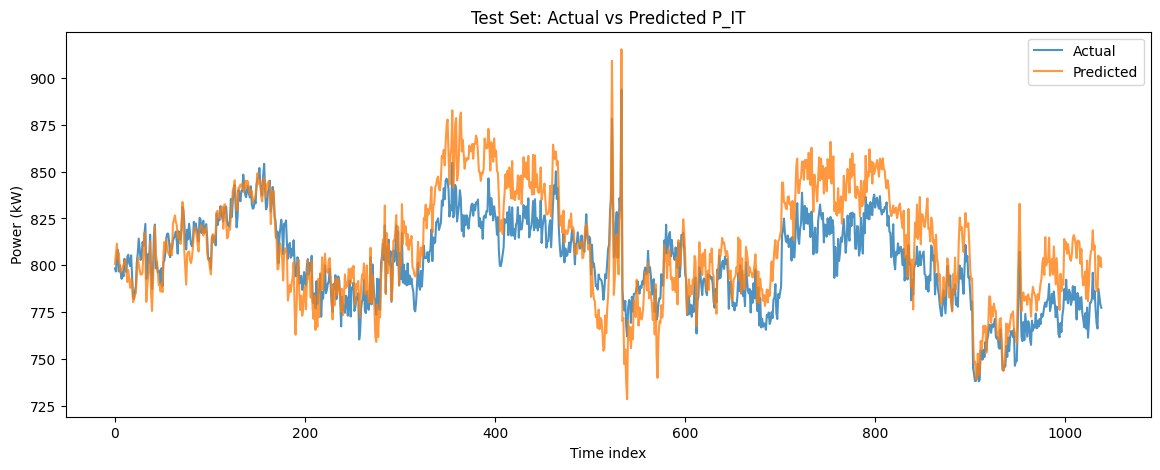

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(ytest.values, label="Actual", alpha=0.8)
plt.plot(y_test_pred, label="Predicted", alpha=0.8)
plt.legend()
plt.title("Test Set: Actual vs Predicted P_IT")
plt.xlabel("Time index")
plt.ylabel("Power (kW)")
plt.show()


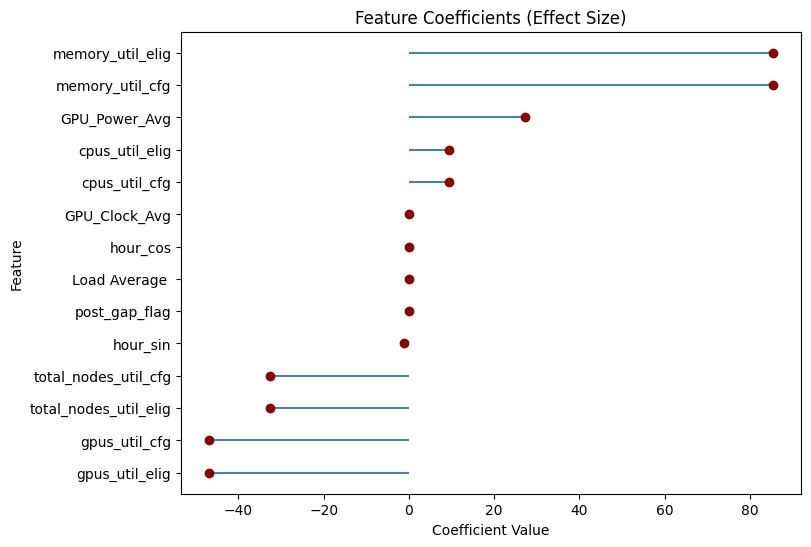

In [22]:


coef_df = model.params.drop('const').sort_values()
plt.figure(figsize=(8,6))
plt.hlines(coef_df.index, 0, coef_df.values, color='steelblue')
plt.plot(coef_df.values, coef_df.index, 'o', color='darkred')
plt.title("Feature Coefficients (Effect Size)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


In [27]:
plt.style.use("seaborn-v0_8-whitegrid")


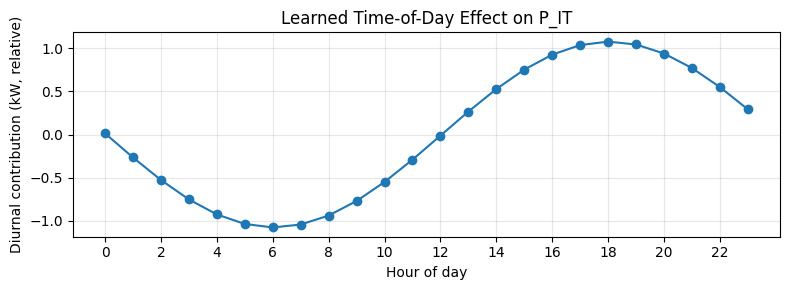

In [ ]:
coefs = pd.Series(model.params, index=model.model.exog_names)

beta_sin = coefs.get('hour_sin', 0.0)
beta_cos = coefs.get('hour_cos', 0.0)

hours = np.arange(24)
hour_sin = np.sin(2*np.pi*hours/24.0)
hour_cos = np.cos(2*np.pi*hours/24.0)

# learned diurnal contribution (relative kW)
hour_effect = beta_sin*hour_sin + beta_cos*hour_cos

plt.figure(figsize=(8,3))
plt.plot(hours, hour_effect, marker='o')
plt.xticks(range(0,24,2))
plt.xlabel("Hour of day")
plt.ylabel("Diurnal contribution (kW, relative)")
plt.title("Learned Time-of-Day Effect on P_IT")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [ ]:
coef_table = pd.DataFrame({
    "Feature": coefs.index,
    "Coefficient (kW per unit)": coefs.values
}).sort_values("Coefficient (kW per unit)", ascending=False)
display(coef_table)


,Feature,Coefficient (kW per unit)
10,memory_util_elig,8.543293e+01
9,memory_util_cfg,8.543293e+01
2,GPU_Power_Avg,2.726429e+01
6,cpus_util_elig,9.455305e+00
5,cpus_util_cfg,9.455305e+00
3,GPU_Clock_Avg,1.452485e-01
14,hour_cos,1.306738e-02
4,Load Average,5.325454e-03
1,post_gap_flag,1.300065e-10
13,hour_sin,-1.078499e+00


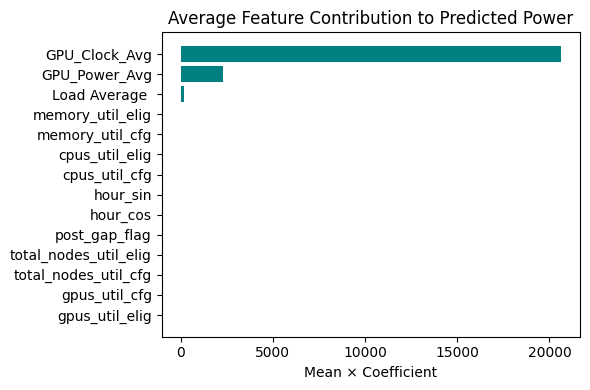

In [25]:
x_mean = xcal.mean()
contribs = (x_mean * model.params.drop("const")).sort_values(ascending=True)

plt.figure(figsize=(6,4))
plt.barh(contribs.index, contribs.values, color='teal')
plt.title("Average Feature Contribution to Predicted Power")
plt.xlabel("Mean × Coefficient")
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [ ]:
xtrain, ytrain = createTargets(training)
xtest,  ytest  = createTargets(testing)

In [ ]:
#Cleaning
res = sm.tsa.SARIMAX(
    exog=xtrain_scaled_df,
    endog=ytrain,
    order=(1,0,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pvals = res.pvalues
sig_cols = [col for col in xtrain.columns if pvals[col] < .05]

In [ ]:
sarima_resid = sm.tsa.SARIMAX(
    exog=xtrain[sig_cols],
    endog=ytrain,
    order=(1,0,1),
    seasonal_order=(1,0,0,144),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


/Users/sameerjivangikar/IdeaProjects/projects/dcpowersims/vip/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Predict residual correction
resid_pred_train = sarima_resid.predict(
    start=0,
    end=len(ytrain) - 1
)
resid_pred_test = sarima_resid.predict(
    start=len(ytrain),
    end=len(ytrain) + len(ytest) - 1
)


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

r2_train = r2_score(ytrain, resid_pred_train)
r2_test  = r2_score(ytest,  resid_pred_test)

rmse_train = np.sqrt(mean_squared_error(ytrain, resid_pred_train))
rmse_test  = np.sqrt(mean_squared_error(ytest,  resid_pred_test))

print(f"Train R²: {r2_train:.3f} | RMSE: {rmse_train:.3f}")
print(f"Test  R²: {r2_test:.3f} | RMSE: {rmse_test:.3f}")


Train R²: 0.988 | RMSE: 6.924
Test  R²: -1.247 | RMSE: 46.249


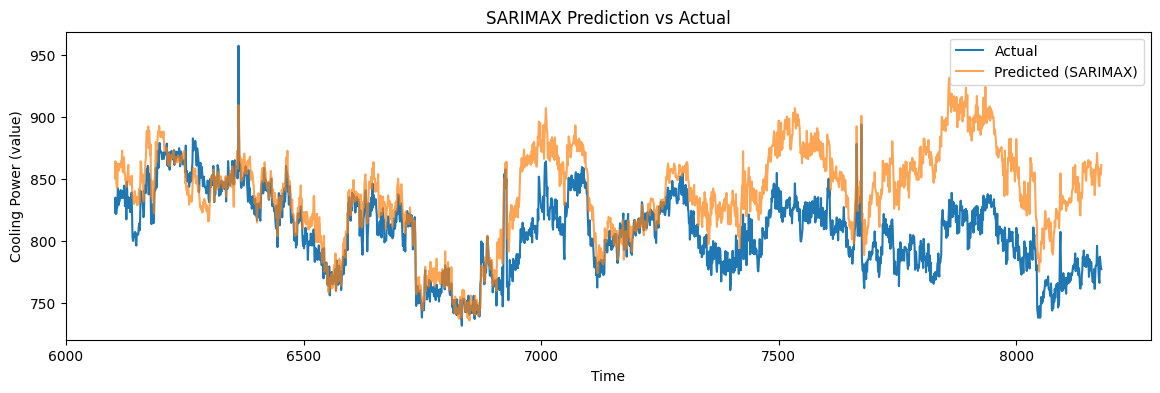

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(ytest.index, ytest, label='Actual')
plt.plot(ytest.index, y_pred_sarimax, label='Predicted (SARIMAX)', alpha=0.7)
plt.title('SARIMAX Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Cooling Power (value)')
plt.legend()
plt.show()

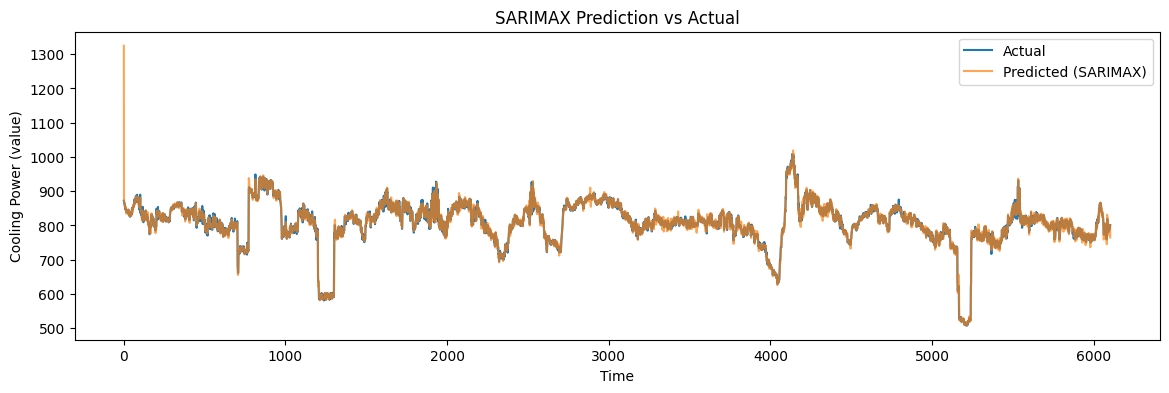

In [ ]:
y_pred_train = res.fittedvalues

plt.figure(figsize=(14,4))
plt.plot(ytrain.index, ytrain, label='Actual')
plt.plot(ytrain.index, y_pred_train, label='Predicted (SARIMAX)', alpha=0.7)
plt.title('SARIMAX Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Cooling Power (value)')
plt.legend()
plt.show()